In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Oct 24

@author: yaning
"""

import importlib
import numpy as np
import matplotlib.pyplot as plt

# my own class files
import without_learning.NN.Receptors as Receptors
import without_learning.NN.Network as Network


importlib.reload(Receptors)
importlib.reload(Network)

path = "/home/yaning/Documents/Spiking_NN/without_learning/"

# import debugpy
# debugpy.listen(("0.0.0.0", 8888))  # Replace 5678 with your desired port number
# print("Debugger is ready. Attach in VS Code.")
# debugpy.wait_for_client()
# # debugpy.breakpoint()  # Optionally set a breakpoint here
# print("Debugger is attached, ready to debug.")

In [3]:
samples = np.load(path + "MCMC_samples/static_std_initial_0.npy") 

In [4]:
cut_samples = samples[1000:, :]

In [5]:
cut_samples.shape

(500, 19)

In [6]:
values = np.mean(cut_samples, axis=0)

In [7]:
values

array([ 0.6227672 ,  0.60953534,  0.62958986,  0.62072325,  0.62922657,
        0.6240698 ,  0.63832563,  0.64734393,  0.6149543 ,  0.63811135,
       30.        , 30.        , 30.        , 30.        , 30.        ,
       30.        , 30.        , 30.        , 30.        ], dtype=float32)

In [26]:
infer_names = Receptors.LigandGatedChannelFactory.infer_names
infer_params = dict(zip(infer_names, values))

In [27]:
Receptors.LigandGatedChannelFactory.infer_params = infer_params

In [28]:
pointCount = 5000
deltaTms = 0.05
times = np.arange(pointCount) * deltaTms
initial_Vm = 1.3458754117369027

# Neuron: deltaTms, I, Vm
neuron_input = Network.Neuron(deltaTms, 0, initial_Vm, "input", 0)

neuron_excite_main = Network.Neuron(deltaTms, 0, initial_Vm, "excite_main", 0)
neuron_excite_sub = Network.Neuron(deltaTms, 0, initial_Vm, "excite_sub", 0)

neuron_inhibit_main = Network.Neuron(deltaTms, 0, initial_Vm, "inhibit_main", 0)
neuron_inhibit_sub = Network.Neuron(deltaTms, 0, initial_Vm, "inhibit_sub", 0)

neuron_output = Network.Neuron(deltaTms, 0, initial_Vm, "output", 0)

neurons = [neuron_input, neuron_excite_main, neuron_excite_sub, 
           neuron_inhibit_main, neuron_inhibit_sub, neuron_output]




# create synapse/connection (send neuron, receive neuron)
control = Network.Control(deltaTms, initial_Vm)


#*********************full layer***************************
# ----------------first input layer------------------------
control.create_synapse(neuron_input, neuron_excite_main, "AMPA")
control.create_synapse(neuron_input, neuron_inhibit_main, "GABA")

# ----------------self recurrent layer----------------
control.create_synapse(neuron_excite_main, neuron_excite_sub, "AMPA+NMDA")
control.create_synapse(neuron_excite_sub, neuron_excite_main, "AMPA+NMDA")

control.create_synapse(neuron_inhibit_main, neuron_inhibit_sub, "GABA")
control.create_synapse(neuron_inhibit_sub, neuron_inhibit_main, "GABA")

# --------------between excitatory and inhibitory----------------
control.create_synapse(neuron_excite_main, neuron_inhibit_main, "AMPA+NMDA")
control.create_synapse(neuron_inhibit_main, neuron_excite_main, "GABA")


# ----------------output layer----------------------
control.create_synapse(neuron_excite_main, neuron_output, "AMPA")




# recording arrays
Vm_neuron_output = []
GABA_gPs = []

# run
for t in range(pointCount):

    # simulate input neuron firing
    # this step changes states of the receptors
    if t >= 2000 and t <= 2047:
        neuron_input.sending_signal()
    

    # update the synapse states then each neuron
    for neuron in neurons:
        neuron.check_firing()
        neuron.update()
        
    # set the synapse states back to 0
    for synapse in control.all_synapses:
        synapse.state = 0


    Vm_neuron_output.append(neuron_excite_main.Vm - 70)
    

        




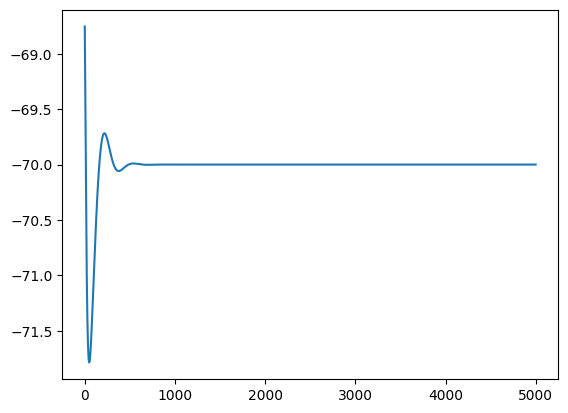

In [29]:
# plt.plot(times, leak_currents, label="leaky")
# plt.plot(times/deltaTms, Ina_currents)
# plt.plot(times/deltaTms, Ik_currents)
# plt.plot(times/deltaTms, Vm_neuron1)
# plt.plot(GABA_gPs)
plt.plot(Vm_neuron_output)
# plt.plot(times/deltaTms, ampa_currents, label = "ampa")


# plt.xlim(2000, 2500)
# plt.ylim(-300, 100)
# plt.legend()

In [8]:
type(Vm_neuron_output)

list

In [9]:
firing = []
for i in Vm_neuron_output:
    if i >= -50:
        firing.append(i)

In [11]:
len(firing)

47

In [12]:
np.max(Vm_neuron_output)

40.1116397661723

NameError: name 'Vm_neuron1' is not defined

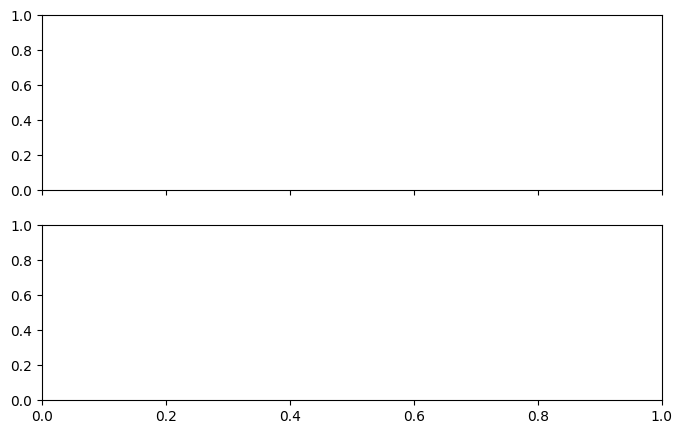

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5),
                                gridspec_kw={'height_ratios': [1, 1]})

ax1.plot(times, Vm_neuron1, label = '1')
ax1.plot(times, Vm_neuron2, label = '2')
ax1.set_ylabel("Membrane Potential (mV)")
# ax1.set_title("Hodgkin-Huxley Spiking Neuron Model", fontSize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(bottom=False)

# ax1.set_ylim(0, 1)


ax2.plot(times, I_neuron1, label = '1')
ax2.plot(times, I_neuron2, label = '2')
ax2.set_ylabel("Currents (µA/cm²)")
ax2.set_xlabel("Simulation Time (milliseconds)")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# ax2.set_ylim(-1,1)
# plt.xlim(98, 120)
plt.margins(0, 0.1)
plt.tight_layout()
plt.legend()
plt.show()

# sharp wave ripples